# Obtaining an O-mode density profile

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import simps
import sys
sys.path.append('../')
sys.path.append('../reflib/')
from reflib import *
from scipy import signal

## Simulating a typical L-mode density profile for ASDEX Upgrade

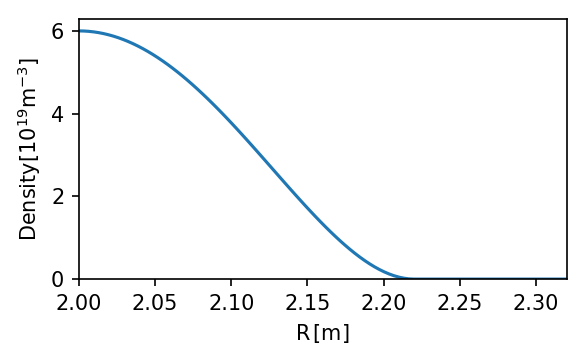

In [2]:
plt.figure(figsize=(4,2.5), dpi=150)
R0 = 2.22
Rant = 2.32
Rmid = 2.0
radius, dens = SimulDensPerf(Rmid=Rmid, R0=R0, Rant=Rant, m=2, n=2)
plt.xlabel('$\mathrm{R\,[m]}$')
plt.ylabel('$\mathrm{Density [10^{19}m^{-3}]}$')
plt.plot(radius, dens*1e-19)
plt.ylim(bottom=0)
plt.xlim(Rmid, Rant)
plt.tight_layout()
plt.show()

## Declaring a frequency sweep

In [3]:
fstart = 18e9
fstop = 60e9
swp_time = 25e-6
Swp_rate = (fstop-fstart)/swp_time
print('Sr='+str(Swp_rate/1e9)+' GHz/s')

Sr=1680000.0 GHz/s


In [4]:
dstart = f2n(fstart)
dstop = f2n(fstop)

## Refractive index

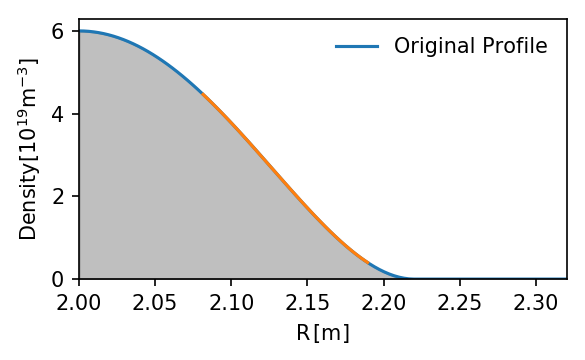

In [5]:
plt.figure(figsize=(4,2.5), dpi=150)
plt.plot(radius, dens*1e-19, label='Original Profile')

fpts = 1024

densint = interp1d(dens, radius)
probing_frequencies = np.linspace(fstart, fstop, fpts, endpoint=True)
probing_densities = f2n(probing_frequencies)
#np.linspace(dstart, dstop, 1024, endpoint=True)
radint = densint(probing_densities)
plt.plot(radint, probing_densities*1e-19)

plt.xlabel('$\mathrm{R\,[m]}$')
plt.ylabel('$\mathrm{Density [10^{19}m^{-3}]}$')
plt.fill_between(radius, dens*1e-19, 0.0, color='k', alpha=0.25)
plt.ylim(bottom=0)
plt.xlim(Rmid, Rant)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

## Refractive index

/home/guimas/anaconda3/envs/ref/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app


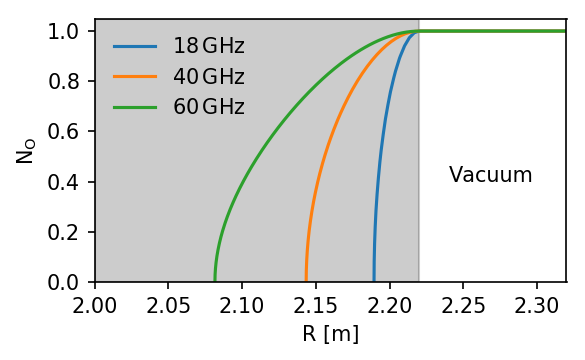

In [6]:
interpts = 8192
interp_perf = interp1d(radius, dens)
interp_rad = interp1d(dens, radius)
total_phase = []

plt.figure(figsize=(4,2.5), dpi=150)

fps = [18, 40, 60]

for fp in fps:
    dens_probe = f2n(fp*1e9)
    r_int = np.linspace(interp_rad(dens_probe), Rant, interpts, endpoint=True)
    n_int = interp_perf(r_int)

    NO = np.sqrt(1-n_int/dens_probe)
    NO[0] = 0.0
    plt.plot(r_int, NO, label='$\mathrm{'+str(fp)+'\,GHz}$')


plt.axvspan(Rmid, R0, color='k', alpha=0.2)
plt.text(2.24, 0.4, 'Vacuum')
plt.ylabel('$\mathrm{N_{O}}$')
plt.xlabel('R [m]')
plt.legend(frameon=False, loc='upper left')
plt.ylim(bottom=0)
plt.xlim(Rmid, Rant)
plt.tight_layout()
plt.savefig('figures/omode_refindex.png', dpi=300)
plt.show()

## Total phase shift

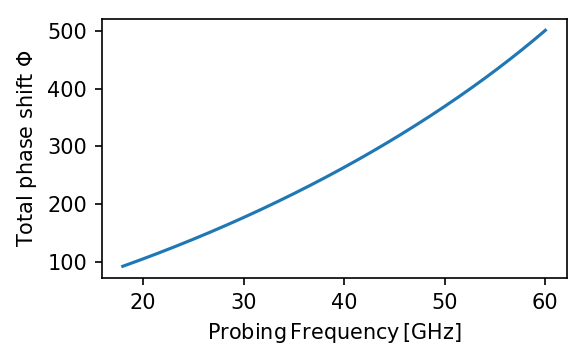

In [7]:
total_phase = []
#Avoid numerical errors due to the sqrt
epsi = 1e-15

#Do a numeric aproach 
for f in probing_frequencies:
    dens_probe = f2n(f)
    r_int = np.linspace(interp_rad(dens_probe)+epsi, Rant, interpts, endpoint=True)
    n_int = interp_perf(r_int)
    #Refractive index
    NO = np.sqrt(1-n_int/dens_probe)
    NO[0] = 0.0
        
    #Refractive index
    total_phase.append( 4.0*np.pi*f/2.998e8*simps(NO, x=r_int)-np.pi/2 )
    
    
#Not interested in the error, hence the [0]
total_phase = np.array(total_phase)

plt.figure(figsize=(4,2.5), dpi=150)

plt.plot(probing_frequencies*1e-9, total_phase)
plt.xlabel('$\mathrm{Probing\,Frequency\,[GHz]}$')
plt.ylabel('Total phase shift $\Phi$')
plt.tight_layout()
#plt.savefig('figures/total_phase_shift.png', dpi=300)
plt.show()

## Simulated signal

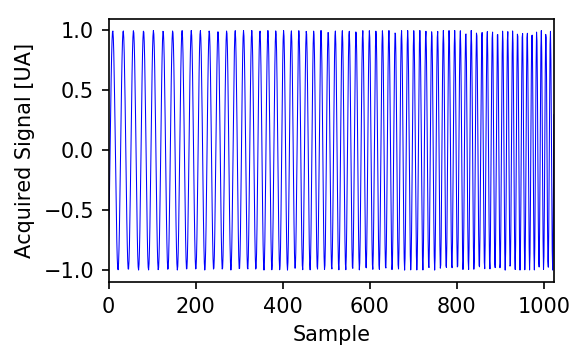

In [8]:
plt.figure(figsize=(4,2.5), dpi=150)
sig = np.cos(total_phase)
plt.xlabel('Sample')
plt.ylabel('Acquired Signal [UA]')
plt.plot(sig, color='blue', lw=0.5)
plt.xlim(0, fpts)
plt.tight_layout()
#plt.savefig('figures/simulated_signal.png', dpi=300)
plt.show()

## Spectral analysis

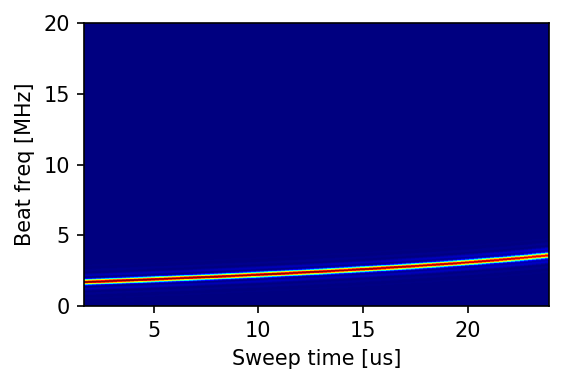

In [9]:
fsamp = 40e6
f, t, Sxx = signal.spectrogram(sig, fsamp*1e-6, nfft=2048, nperseg=136, noverlap=128)#, nperseg=32, noverlap=16)

plt.figure(figsize=(4,2.5), dpi=150)

plt.pcolormesh(t, f, Sxx, cmap='jet')
#plt.ylim(0, 4.0)
plt.xlabel('Sweep time [us]')
plt.ylabel('Beat freq [MHz]')
plt.show()

## Extracting the beat frequency

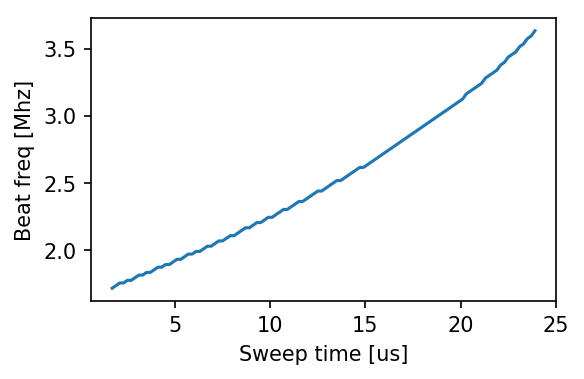

In [10]:
plt.figure(figsize=(4,2.5), dpi=150)

beat_f = f[np.argmax(Sxx, axis=0)]

plt.plot(t, beat_f)
#plt.ylim(0, 2.)
plt.xlabel('Sweep time [us]')
plt.ylabel('Beat freq [Mhz]')
plt.show()

## Best-path?

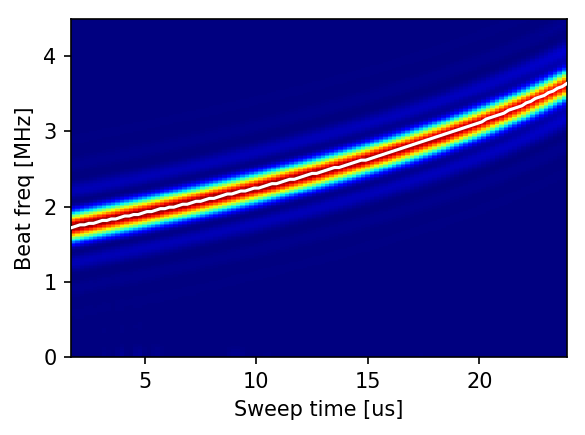

In [11]:
fsamp = 40e6
f, t, Sxx = signal.spectrogram(sig, fsamp*1e-6, nfft=2048, nperseg=136, noverlap=128)#, nperseg=32, noverlap=16)

beat_f = f[np.argmax(Sxx, axis=0)]

plt.figure(figsize=(4,3.), dpi=150)

plt.pcolormesh(t, f, Sxx, cmap='jet')
plt.plot(t, beat_f, zorder=10, color='w')
plt.ylim(0, 4.5)
plt.xlabel('Sweep time [us]')
plt.ylabel('Beat freq [MHz]')
plt.tight_layout()
plt.show()

## Group delay

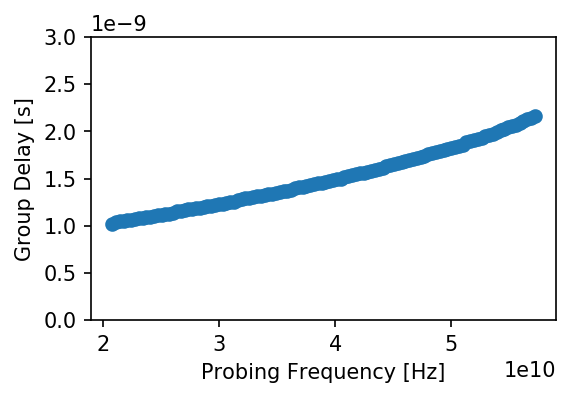

In [12]:
tau_g = beat_f*1e6 / Swp_rate
f_probsw = t*1e-6/(1024.0/fsamp)*(fstop-fstart) + fstart

plt.figure(figsize=(4,2.5), dpi=150)
plt.scatter(f_probsw, tau_g)
plt.ylim(0, 3e-9)
plt.xlabel('Probing Frequency [Hz]')
plt.ylabel('Group Delay [s]')
plt.show()

## Group delay

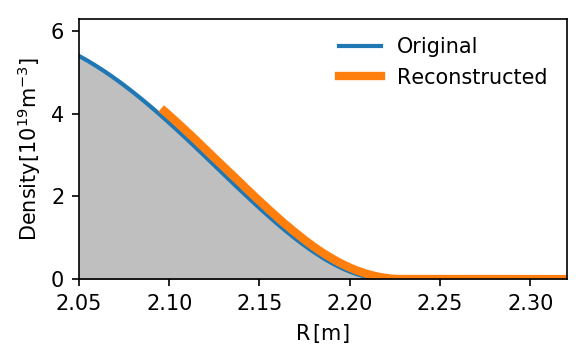

In [15]:
plt.figure(figsize=(4,2.5), dpi=150)
plt.xlabel('$\mathrm{R\,[m]}$')
plt.ylabel('$\mathrm{Density [10^{19}m^{-3}]}$')
plt.fill_between(radius, dens*1e-19, 0.0, color='k', alpha=0.25)
plt.ylim(bottom=0)
plt.xlim(Rmid, Rant)
plt.tight_layout()

Rinit = 2.23
r, n, fpro, gdel = CalcInvPerfO(f_probsw, tau_g, vacd=Rant-Rinit)
plt.plot(radius, dens*1e-19, label='Original', lw=2)
R_reco = Rant-r
plt.plot(R_reco, n*1e-19, label='Reconstructed', lw=4)
plt.xlim(2.05, 2.32)
plt.legend(frameon=False)
plt.tight_layout()

#plt.savefig('figures/Reconstructed_profile.png', dpi=300)
plt.show()

## Reconstruction error

Text(0, 0.5, 'Error [cm]')

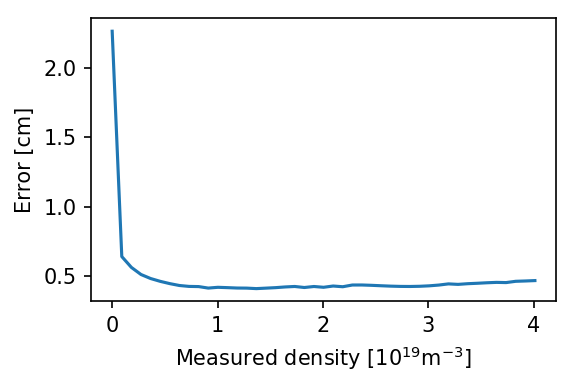

In [22]:
common_dens = np.linspace(0.0, dstop)
reconstructed_int = interp1d(n, R_reco, bounds_error=False)
original_int = interp1d(dens, radius, bounds_error=False)

error_reconstruction = np.abs(original_int(common_dens)-reconstructed_int(common_dens))

plt.figure(figsize=(4,2.5), dpi=150)
plt.plot(common_dens*1e-19, error_reconstruction*1e2)
plt.xlabel('Measured density $\mathrm{[10^{19}m^{-3}]}$')
plt.ylabel('Error [cm]')